# Homework nr. 1 - data visualization (deadline 25/10/2018)

In short, the main task is to download data on theses defended at CTU from the Internet, store them in pandas Data Frame and then visualize some hidden information.
  
> The instructions are not given in details: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can. Thinking of how to visualize the data is an important part of data visualization! ;)

## What are you supposed to do:

  1. Browse the web https://dspace.cvut.cz/?locale-attribute=en and find out how to download data on Bachelor and Master theses.
  2. Download or scrape the data such that for each thesis you know the following:
    * Faculty name, department name, thesis title, thesis type (bachelor/master), supervisor name, reviewer name, year (or date) of the defence, study programme and discipline, link to a webpage with details.
  3. Store these data in one _csv_ file (should be handed in along with this notebook).
  4. Use tools available for Python to plot charts and tables to visualize/display this information:
    * Number of defended theses per year for CTU/Faculties. Distinguish the type of thesis.
    * Find the departments/study programmes/supervisors/reviewers with highest numbers of thesis and come up with some nice plots and tables to depict their numbers.
    * Mean/median/minimum/maximum number of supervised theses per year for faculties.
    * Number (or fraction) of theses supervised by people with various degrees (Bc./Ing./Ph.D./ ...).

**If you do all this properly, you will obtain 6 points**

To earn **extra two points** you can do some of these:
  * Use http://beakerx.com to make your notebook interactive in a meaningful way.
  * Come up with some other reasonable and interesting views of data.
  * Use your data to create an interactive webpage (HTML + JavaScript).

## Comments

  * Please follow the instructions from https://courses.fit.cvut.cz/MI-PDD/homeworks/index.html.
  * If the reviewing teacher is not satisfied, he can give you another chance to rework your homework and to obtain more points.

# Imports, Constants and Functions

In [895]:
import numpy as np
import pandas as pd
import sklearn as skit
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

import requests
from bs4 import BeautifulSoup
import os
import csv

import re

%matplotlib inline
matplotlib.style.use('ggplot')

def getName(soup):
    return soup.select(".col-xs-10 a")[0].getText()
def getId(href):
    return href.replace("/handle/10467/","")
def getUrl(soup):
    return soup.select(".col-xs-10 a")[0]['href']
def getNumberOfDocuments(soup):
    a = re.search('\[([0-9]*)\]', soup.getText())
    return a.group(1)
def getPropertiesObject(soup):
    object = {'href': None ,'name': None, 'id': None, 'count': None, 'descendants': []}
    object['href'] = getUrl(soup)
    object['name'] = getName(soup)
    object['count'] = getNumberOfDocuments(soup)
    object['id'] = getId(object['href'])
    return object
def getInnerText(soup, index):
    try: soup[index]
    except IndexError: return ''
    header = soup[index].getText().strip()
    inner_text = soup[index].find_parent('div').getText()
    return inner_text.replace(header, '').strip()

HOST = 'https://dspace.cvut.cz'
DOWNLOADS_DIR = 'webfiles'
COMMUNITY_LIST = 'community-list'
DOWNLOADLIST_CSV = 'downloadlist.csv'
DATA_CSV = 'data.csv'

# Scraping
## Community List
If the website https://dspace.cvut.cz/community-list is not saved yet, the code below will download and save it into website folder.

Note: The website folder have to exists before running the code.

Then, the code will open the file again (for the case the website is not saved yet) and scape the data from the html like names of the faculties, deparments and links that point to their listing pages. All these data are stored in the array pagesToScrap.

In [896]:
print('[Community-list]')
pathCommunityList = os.path.join(DOWNLOADS_DIR,COMMUNITY_LIST)
if not os.path.isfile(pathCommunityList):
    print('\t - Downloading Community List')
    r = requests.get(HOST+'/'+COMMUNITY_LIST)
    file = open(pathCommunityList, 'w')
    file.write(r.text)

html = open(pathCommunityList).read()
soup = BeautifulSoup(html, 'html.parser')
faculties = soup.select("#collapse-10467_3641 > .community-browser-row")
pagesToScrap = []
for faculty in faculties:
    facultyObj = getPropertiesObject(faculty)
    departments = faculty.find_parent('div').select('#collapse-10467_'+facultyObj['id']+' > .community-browser-row')
    for department in departments:
        departmentObj = getPropertiesObject(department)
        documents = department.find_parent('div').select('#collapse-10467_'+departmentObj['id']+' > .community-browser-row')
        for document in documents:
            documentObj = getPropertiesObject(document)
            match = re.search('(Bakalářské práce)|(Diplomové práce)', documentObj['name'])
            if match:
                documentObj['name'] = match.group(0)
                for i in range(0, int(documentObj['count']), 20):
                    pageObj = {
                        'faculty': facultyObj['name'],
                        'department': departmentObj['name'],
                        'document': documentObj['name'],
                        'url': '/handle/10467/'+documentObj['id']+'?offset='+str(i),
                        'thesisUrls': []
                    }
                    pagesToScrap.append(pageObj)

[Community-list]


## Listing Pages

The following code will download all the listing pages and save into ./webfiles/handle/10467. Afterwards, the it will the get urls of theses and titles. It also checks if pages were already downloaded. Then, it will save the partial data like faculty, department, thesis name and scrapped url in the separate file for the final download of theses pages.

In [897]:
print("\t - Downloading listing pages")
for pageObj in pagesToScrap:
    s = pageObj['url'].split('/')
    filename = os.path.join(DOWNLOADS_DIR,*s)
    if not os.path.isfile(filename):
        print('\t\t - Downloading: ' + pageObj['url'])
        r = requests.get(HOST+pageObj['url'])
        file = open(filename, 'w')
        file.write(r.text)

thesesPages = []
print('[Listing Pages]')
print("\t - Getting urls from listing pages")
pathCsv = os.path.join(DOWNLOADLIST_CSV)
if not os.path.isfile(pathCsv):
    for pageObj in pagesToScrap:
        print('\t\t - Scrapping: ' + pageObj['url'])
        s = pageObj['url'].split('/')
        filename = os.path.join(DOWNLOADS_DIR,*s)
        html = open(filename).read()
        tableSoup = BeautifulSoup(html, 'html.parser')
        urls = tableSoup.select("h4.artifact-title a")
        for url in urls:
            thesisPage = {
                'faculty': pageObj['faculty'],
                'department': pageObj['department'],
                'document': pageObj['document'],
                'name': None,
                'link': None
                }
            thesisPage['name'] = url.getText().strip()
            thesisPage['link'] = url['href']
            thesesPages.append(thesisPage)
    csvFile = open(pathCsv, 'w')
    writer = csv.DictWriter(csvFile, fieldnames=thesesPages[0].keys())
    writer.writeheader()
    for thesisPage in thesesPages:
        writer.writerow(thesisPage)

	 - Downloading listing pages
[Listing Pages]
	 - Getting urls from listing pages


## Theses Pages

The final download&scrapping block will take all the urls from the file created in the previous code block, then it will download and scrape them. The product of the following code will be also saved in the separate file, thus all the code blocks above needn't to be run every single start of this jupyter notebook.

In [898]:
downloadListCSVFile = open(DOWNLOADLIST_CSV, 'r')
reader = csv.DictReader(downloadListCSVFile)
print('[Thesis Pages]')
print('\t - Downloading the thesis pages')
for row in reader:
    s = row['link'].split('/')
    filename = os.path.join(DOWNLOADS_DIR,*s)
    if not os.path.isfile(filename):
        print('\t\t - Downloading: ' + row['link'])
        r = requests.get(HOST+row['link'])
        file = open(filename, 'w')
        file.write(r.text)

theses = []
pathDataCSV = os.path.join(DATA_CSV)
if not os.path.isfile(pathDataCSV):
    print('\t - Getting information from the thesis pages')
    downloadListCSVFile2 = open(DOWNLOADLIST_CSV, 'r')
    reader = csv.DictReader(downloadListCSVFile2)
    for row in reader:
        print('\t\t - Scrapping: ' + row['link'])
        s = row['link'].split('/')
        filename = os.path.join(DOWNLOADS_DIR,*s)
        html = open(filename).read()
        tableSoup = BeautifulSoup(html, 'html.parser')
        properties = tableSoup.select("#aspect_artifactbrowser_ItemViewer_div_item-view .col-sm-12 .row .col-xs-6 div h5")
        author = getInnerText(properties,1)
        supervisor = getInnerText(properties,2)
        reviewer = getInnerText(properties,3)
        date_defended = getInnerText(properties,7)
        study_programme = getInnerText(properties,5)
        field_of_study = getInnerText(properties,4)
        institutions_assigning_rank = getInnerText(properties,6)
        thesis = {
            'faculty': row['faculty'],
            'department': row['department'],
            'document': row['document'],
            'name': row['name'],
            'author': author,
            'supervisor': supervisor,
            'reviewer': reviewer,
            'date_defended': date_defended,
            'study_programme': study_programme,
            'field_of_study': field_of_study,
            'institutions_assigning_rank': institutions_assigning_rank,
            'link': HOST+row['link']
        }
        theses.append(thesis)

    dataCsvFile = open(pathDataCSV, 'w')
    writer = csv.DictWriter(dataCsvFile, fieldnames=theses[0].keys())
    writer.writeheader()
    for thesis in theses:
        writer.writerow(thesis)

[Thesis Pages]
	 - Downloading the thesis pages


# Visualisations

In [899]:
# read csv
df = pd.read_csv('data.csv', sep=',', quotechar='"', parse_dates=['date_defended'])

#add column year derivated from date_defended column
df['date_defended'] = pd.to_datetime(df['date_defended'])
df['year_defended'] = round(df['date_defended'].dt.year)

### Error: Duplicate urls

I discovered that some theses were listed in more listing page. Also, some listing pages had the same content, even though they have different URL. I don't know why, but I should be able to fix it with little bit cleansing.

In [900]:
df = df.drop_duplicates()
df

,faculty,department,document,name,author,supervisor,reviewer,date_defended,study_programme,field_of_study,institutions_assigning_rank,link,year_defended
0,Fakulta architektury,kabinet modelového projektování,Diplomové práce,UDRŽITELNÝ BAZÉN ČESKÝ BROD,Chotěbor Adam,Achten Henri Hubertus,Hladík Pavel,2018-06-13,Architektura a urbanismus,Architektura,ústav modelového projektování,https://dspace.cvut.cz/handle/10467/78337,2018
1,Fakulta architektury,kabinet modelového projektování,Diplomové práce,UDRŽITELNÁ MATEŘSKÁ ŠKOLA ČESKÝ BROD,Cyprianová Lucia,Achten Henri Hubertus,Murgaš Richard,2018-06-13,Architektura a urbanismus,Architektura,ústav modelového projektování,https://dspace.cvut.cz/handle/10467/78328,2018
2,Fakulta architektury,kabinet modelového projektování,Diplomové práce,HABITAT V OÁZE SIWA. EGYPT,Fišera Jakub,Florián Miloš,Šimkovič Vladimír,2018-06-13,Architektura a urbanismus,Architektura,ústav modelového projektování,https://dspace.cvut.cz/handle/10467/77239,2018
3,Fakulta architektury,kabinet modelového projektování,Diplomové práce,MULTIMODÁLNÍ DOPRAVNÍ TERMÍNÁL PRAHA RUZYNĚ,Pokoj Ondřej,Florián Miloš,Klokočka Jiří,2018-06-13,Architektura a urbanismus,Architektura,ústav modelového projektování,https://dspace.cvut.cz/handle/10467/76872,2018
4,Fakulta architektury,kabinet modelového projektování,Diplomové práce,MRAKODRAP 610 LEXINGTON AVENUE,Pospíšil Dalibor,Achten Henri Hubertus,Kaftan Martin,2018-02-06,Architektura a urbanismus,Architektura,ústav modelového projektování,https://dspace.cvut.cz/handle/10467/75939,2018
5,Fakulta architektury,kabinet modelového projektování,Diplomové práce,HABITAT V OÁZE SIWA. EGYPT,Fišera Jakub,Florián Miloš,Šimkovič Vladimír,2018-02-06,Architektura a urbanismus,Architektura,kabinet modelového projektování,https://dspace.cvut.cz/handle/10467/74467,2018
6,Fakulta architektury,kabinet modelového projektování,Diplomové práce,CENTRUM HALOVÝCH SPORTŮ ČESKÉ BUDĚJOVICE,Císař Martin,Achten Henri Hubertus,Hladík Pavel,NaT,Architektura a urbanismus,Architektura,kabinet modelového projektování,https://dspace.cvut.cz/handle/10467/74413,NaN
7,Fakulta architektury,kabinet modelového projektování,Diplomové práce,"SKODA MUSEUM, PRAGUE",Baćević Ognjen,Achten Henri Hubertus,Obůrka Jakub,NaT,Architecture and Urbanism,Architektura,kabinet modelového projektování,https://dspace.cvut.cz/handle/10467/74088,NaN
8,Fakulta architektury,kabinet modelového projektování,Diplomové práce,SPORTOVNÍ HALA - ČESKÉ BUDĚJOVICE,Fál Václav,Achten Henri Hubertus,Hladík Pavel,NaT,Architektura a urbanismus,Architektura,kabinet modelového projektování,https://dspace.cvut.cz/handle/10467/74084,NaN
9,Fakulta architektury,kabinet modelového projektování,Diplomové práce,PAVILON PRO PANDY ZOO PRAHA,Mejsnarová Lucie,Achten Henri Hubertus,Kvita Jan,2017-06-14,Architektura a urbanismus,Architektura,kabinet modelového projektování,https://dspace.cvut.cz/handle/10467/72981,2017


## 1 Number of defended theses per year
A plot of defended theses of all faculties that also distinguish thesis type is a bit messy, so I just show table and the visualisation is split into 3 subtasks. The first plot shows number of defended theses per year for entire CTU, the second is similar, but distinguish faculty not the thesis type and the last plot is actually a series of plots that distinguish thesis type for each faculty. Also, the visualisations below show just data in the time interval from 2011 to 2018, because of missing dates in records outside of the interval.

In [901]:
df.groupby(['year_defended','document', 'faculty'])['year_defended'].count()

year_defended  document          faculty                               
2006           Bakalářské práce  Fakulta biomedicínského inženýrství        43
2007           Bakalářské práce  Fakulta biomedicínského inženýrství        42
2008           Bakalářské práce  Fakulta biomedicínského inženýrství        37
               Diplomové práce   Fakulta biomedicínského inženýrství        30
2009           Bakalářské práce  Fakulta biomedicínského inženýrství        83
               Diplomové práce   Fakulta biomedicínského inženýrství        63
2010           Bakalářské práce  Fakulta biomedicínského inženýrství        82
               Diplomové práce   Fakulta biomedicínského inženýrství        45
2011           Bakalářské práce  Fakulta architektury                      191
                                 Fakulta biomedicínského inženýrství        59
                                 Fakulta dopravní                          190
                                 Fakulta elektrotechnická  

### 1.1 Number of defended theses per year

document,Bakalářské práce,Diplomové práce
year_defended,,
2011,1959,2092
2012,2062,1908
2013,2580,2116
2014,1921,1635
2015,1082,833
2016,1207,914
2017,1349,1318
2018,506,570


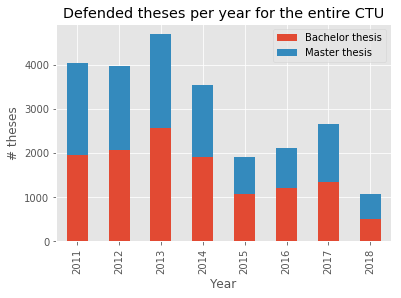

In [902]:
# I could not find the proper way how to get rid of zeros after decimal point in year
import matplotlib.ticker as tick
def x_fmt(x, y):
    return str(int('{:d}'.format(x))+2011)

df2 = df[(df['year_defended'] > 2010) & (df['year_defended'] < 2019)].groupby(['year_defended','document'])['year_defended'].count().unstack('document').fillna(0)
ax = df2.plot(kind='bar', stacked=True, title="Defended theses per year for the entire CTU")
ax.set_xlabel("Year")
ax.set_ylabel("# theses")
ax.legend(["Bachelor thesis", "Master thesis"])
ax.xaxis.set_major_formatter(tick.FuncFormatter(x_fmt))
df2

### 1.2 Defended theses per year by faculty

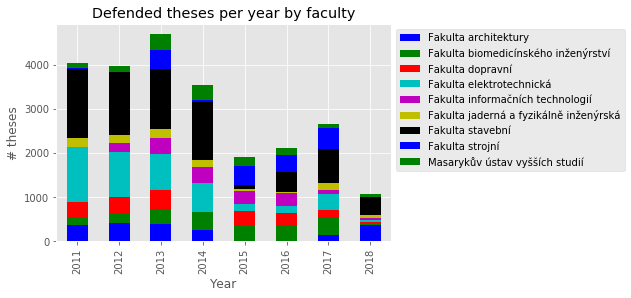

In [903]:
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk') # just to add more colors

df22 = df[(df['year_defended'] > 2010) & (df['year_defended'] < 2019)].groupby(['year_defended','faculty'])['year_defended'].count().unstack('faculty')
ax = df22.plot(kind='bar', stacked=True, title="Defended theses per year by faculty")
ax.set_xlabel("Year")
ax.set_ylabel("# theses")
ax.legend(loc=0, bbox_to_anchor=(1, 1))
ax.xaxis.set_major_formatter(tick.FuncFormatter(x_fmt))

### 1.3 Defended theses per year for each faculty

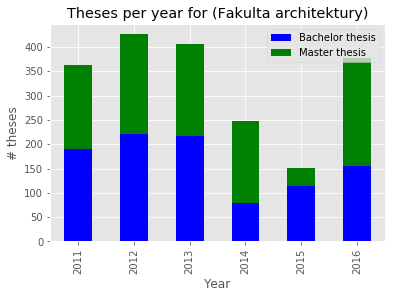

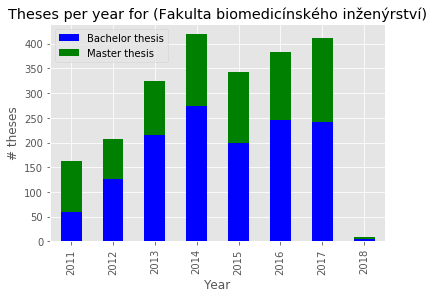

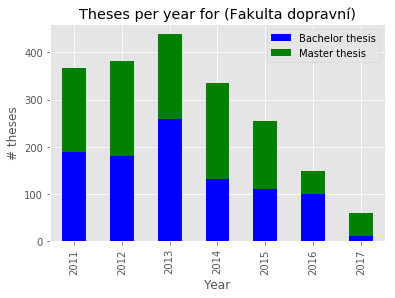

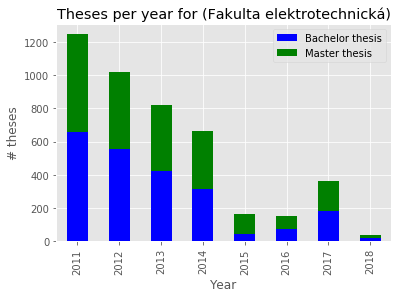

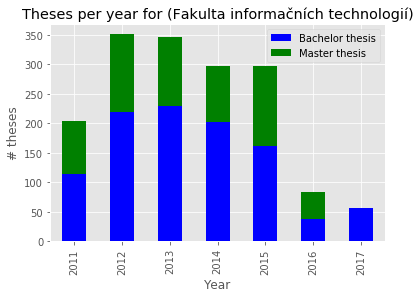

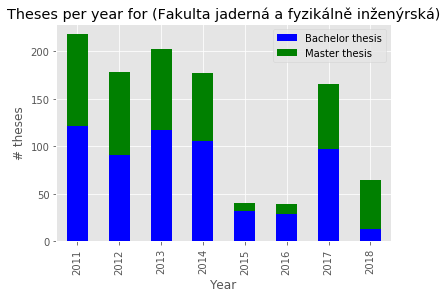

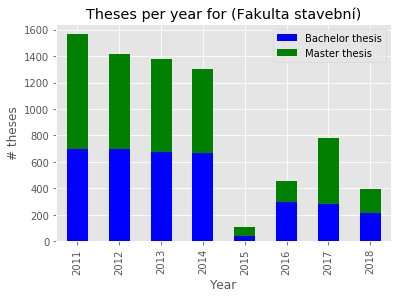

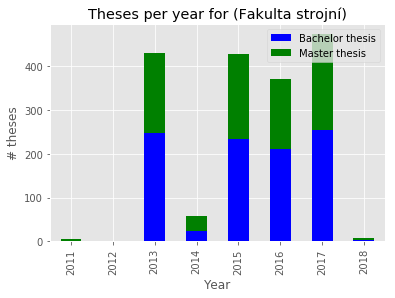

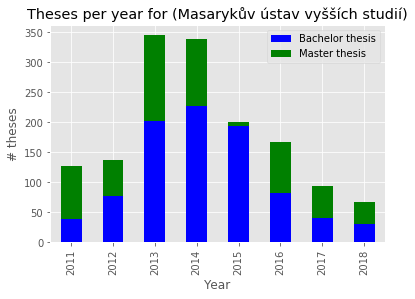

In [904]:
for faculty in df['faculty'].unique():
    dfPerFaculty = df[(df['year_defended'] > 2010) & (df['year_defended'] < 2019) & (df['faculty'] == faculty)].groupby(['year_defended','document'])['year_defended'].count().unstack('document').fillna(0)
    ax = dfPerFaculty.plot(kind='bar', stacked=True, title="Theses per year for ("+faculty+")")
    ax.set_xlabel("Year")
    ax.set_ylabel("# theses")
    ax.legend(["Bachelor thesis", "Master thesis"])
    ax.xaxis.set_major_formatter(tick.FuncFormatter(x_fmt))
    plt.show()

## 2. Departments/study Programmes/supervisors/reviewers with highest number of theses

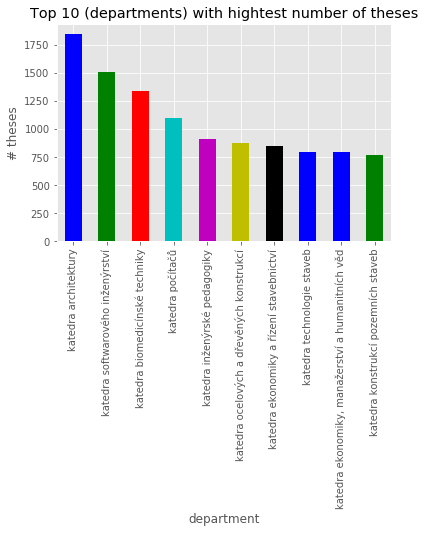

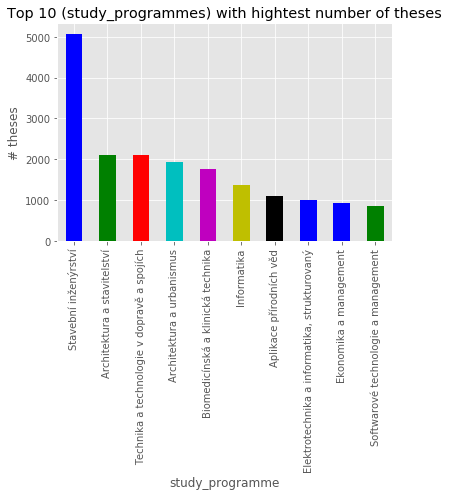

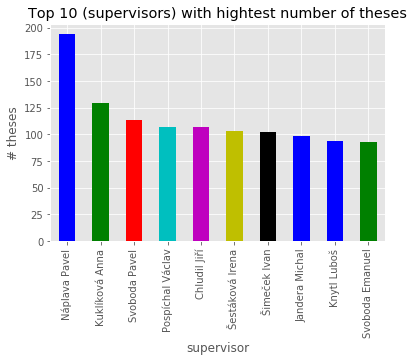

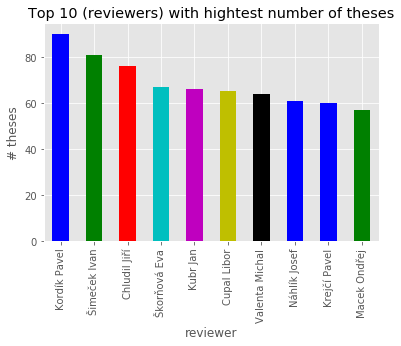

In [905]:
columns = ['department', 'study_programme', 'supervisor', 'reviewer']

for column in columns:
    df3 = df.groupby([column]).size().sort_values(ascending=False).head(10)
    ax = df3.plot(kind='bar', title="Top 10 ("+column+"s) with hightest number of theses")
    ax.set_ylabel('# theses')
    plt.show()

## 3. Mean/median/minimum/maximum number of supervised theses per year for faculties

Note: On the fifth row in code, there is a check for rows with an empty value in the 'supervisor' column. Unless the every thesis could not be unsupervised, this check in not needed, but it is good to use it just for the case the thesis could be unsupervised in the future.

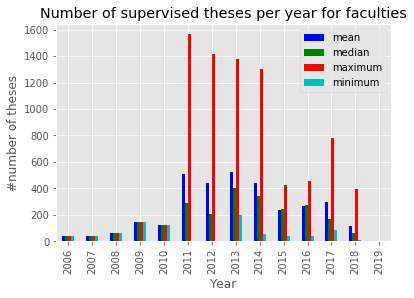

In [906]:
aggFncs = {'Mean':np.mean,'Median':np.median,'Maximum':np.max,'Minimum':np.min}
tmp = []
def x_fmt2(x, y):
    return str(int('{:d}'.format(x))+2006)

for key in aggFncs:
    df4 = df[df['supervisor'].notnull()].groupby(['year_defended','faculty'])['year_defended'].count().reset_index(name="count").groupby(['year_defended']).agg({'count': aggFncs[key]}).reset_index()
    tmp.append(df4)
temp = pd.merge(tmp[0], tmp[1], on="year_defended", how="left")
temp = pd.merge(temp, tmp[2], on="year_defended", how="left")
temp = pd.merge(temp, tmp[3], on="year_defended", how="left")
temp.columns=['year', 'mean', 'median', 'maximum', 'minimum']
ax = temp.plot(x='year', kind='bar', title="Number of supervised theses per year for faculties")
ax.set_xlabel('Year')
ax.set_ylabel('#number of theses')
ax.xaxis.set_major_formatter(tick.FuncFormatter(x_fmt2))

# Bonus
## The highest concentration of theses made by chinks per faculty
\#NotToBeRacistOrAnythingButAsianPeople \#DontTakeItSeriosly \#MyAsianFriendsWillForgiveMe \#NoOffense

I searched for some most used Vietnamese surnames and first names and I made a list of them. I tried even more names, but adding them did not led to add more records to matching. Of course, some rows might not be covered, but most of them should be.

The plot below shows an interesting fact, that the most theses made by vietnamese people were made at faculty of architecture. This is a bit surprising, because I expected faculty of information technology or other technical and computer based faculty.

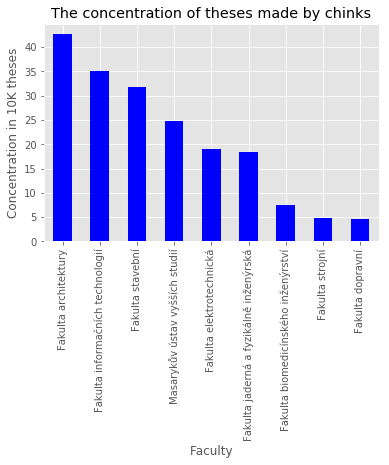

In [907]:
chinkyNames = ['Nguyen', 'Tran ', 'Tran^', 'Pham', 'Huynh', 'Hoang', 'Linh ', 'Trang', 'Phuong', 'Thi ', 'Duc ',]

dfChinks = df[df['author'].str.contains('|'.join(chinkyNames), na=False)].groupby('faculty')['author'].count().reset_index(name='count');
dfAll = df.groupby('faculty')['author'].count().reset_index(name='count')
dfDiv = pd.merge(dfChinks, dfAll, on="faculty", how="left")
dfDiv['division'] = dfDiv['count_x']/dfDiv['count_y']*10000
ax = dfDiv[['faculty','division']].sort_values(by='division',ascending=False).plot(x='faculty', kind='bar',legend=False, title='The concentration of theses made by chinks')
ax.set_ylabel('Concentration in 10K theses');
ax.set_xlabel('Faculty');

# Bonus 2
## Number of students that made both thesis at the same faculty

At first, I filter students that defended bachelor thesis no less than 3 years ago, just to filter out students, who still study master's. Then, I do a left outer join on students, who defended both theses. Then, I group tables by faculty. Then, I do an inner join on faculties. At last, I just divide counts and plot the results. I know about the error, that some students might have the same name, but the error should not be crucial. Just to be sure, I filter out rows with more than one appearence of the name in bachelor or master theses. It is good to point out that bachelor thesis with lower year of defence than master thesis for a single student is not relevant.

An interesting fact is, that the faculty of information technology has really low percentage of the above mentioned students. This is not actually surprising, because the faculty has the problem, that their students move to study at different faculty, leave studies after bachelors or move to stady at a different university. And the faculty did some steps in the last couple of years to attract their student to stay on the faculty.

Text(0.5,0,'')

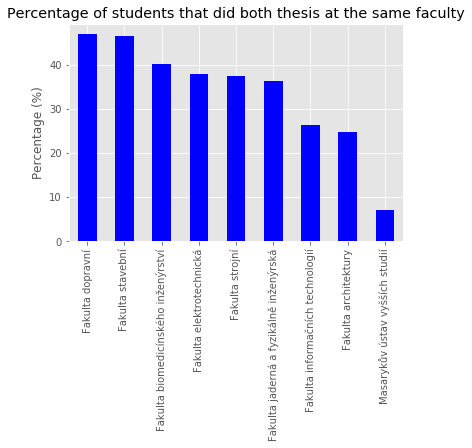

In [908]:
df6 = df[(df['document'] == 'Bakalářské práce') & (df['year_defended'] < 2017)] # co udelali bakuli
df6Cleansed = df6.groupby('author').size().reset_index(name='count')
df6Cleansed = df6Cleansed[(df6Cleansed['count'] < 2)]
df6 = pd.merge(df6, df6Cleansed, on='author') 

df7 = df[(df['document'] == 'Diplomové práce')]
df7Cleansed = df7.groupby('author').size().reset_index(name='count')
df7Cleansed = df7Cleansed[(df7Cleansed['count'] < 2)]
df7 = pd.merge(df7, df7Cleansed, on='author') 

df8 = pd.merge(df6, df7, how='left', on='author') # studenti co udelali oboje

df8 = df8[(df8['year_defended_x'] < df8['year_defended_y'])]
df8PerFaculty = df8.groupby('faculty_x').size().reset_index(name='count')
df8PerFaculty.columns = ['faculty', 'count']
df6PerFaculty = df6.groupby('faculty').size().reset_index(name='count')
df9 = pd.merge(df6PerFaculty, df8PerFaculty, on='faculty')

df9['division'] = (df9['count_y']/df9['count_x'])*100
df9 = df9.sort_values(by='division', ascending=False)
ax = df9[['faculty', 'division']].plot(kind='bar', x='faculty', legend=False, title='Percentage of students that did both thesis at the same faculty')
ax.set_ylabel('Percentage (%)')
ax.set_xlabel('')





# Bonus 3
## Percentage of students who moved from FIT to FEL for each year
It is well-known, that many FIT students get bothered by math throughout bachelor studies at FIT and they rather go to study at FEL. The plot below just show, that almost 10 % students, who defended their bachelor thesis at FIT, went to study at FEL, where they defended their master thesis.

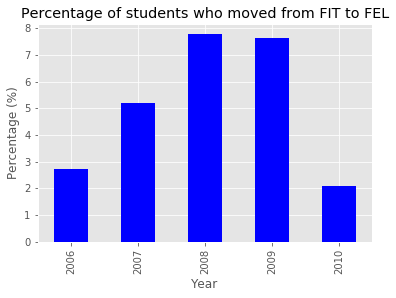

In [912]:
df30 = df6[(df6['faculty'] == 'Fakulta informačních technologií')]
df31 = df7[(df7['faculty'] == 'Fakulta elektrotechnická')]
df32 = pd.merge(df30, df31, on='author')
df33 = df32.groupby('year_defended_x').size().reset_index(name='count')
df33.columns = ['year_defended', 'count']
df34 = df30.groupby('year_defended').size().reset_index(name='count')
df35 = pd.merge(df33, df34, on='year_defended')
df35['division'] = df35['count_x']/df35['count_y']*100
ax = df35[['year_defended','division']].plot(legend=False, kind='bar', x='year_defended', title='Percentage of students who moved from FIT to FEL')
ax.set_xlabel('Year')
ax.set_ylabel('Percentage (%)')
ax.xaxis.set_major_formatter(tick.FuncFormatter(x_fmt2))